# Setup

In [0]:
REMOTE_COLAB = True  # wether or not you are running this on remote colab

In [2]:
if REMOTE_COLAB is True:
    # Instalação de bibliotecas e datasets necessários no colab remoto
    print("Verificando instalação do torch e bibliotecas extras necessárias...")
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
    
    !pip3 install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    
    # PIL workaround 
    from PIL import Image
    def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
    Image.register_extension = register_extension
    def register_extensions(id, extensions): 
        for extension in extensions: register_extension(id, extension)
    Image.register_extensions = register_extensions
    
    #print("AGORA REINICIE O KERNEL ANTES DE CONTINUAR!")
    !nvidia-smi
        
print("\nChecando GPU...")
# Check de GPU, caso não apareça uma GPU ou memória livre, tente utilizar outra máquina do colab
import torch   
print("Dispositivo cuda disponível? ", end='')
if torch.cuda.is_available() is True:
    device = torch.device("cuda:0")
    print("sim: " + str(device))
    from torch.cuda import get_device_name
    print("GPU:" + str(get_device_name(0))) 
else:
    device = torch.device("cpu")
    print("não. Usando CPU.")
    

Verificando instalação do torch e bibliotecas extras necessárias...
Tue Oct 16 12:55:58 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:        

In [0]:
!wget -nc -q https://raw.githubusercontent.com/robertoalotufo/files/master/lib/pytorch_trainer_v2.py -Plib/

In [4]:
print("Importando bibliotecas...")
# Standard libs
import time
import os
import copy
import pickle
from math import sqrt, pow
import traceback
from random import random
from collections import OrderedDict

# 3rd party libs
from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms


print("Versão do PyTorch: " + str(torch.__version__))
print("Versão do OpenCV: " + str(cv.__version__))


plt.ion()   # interactive mode

print("Pronto!")

Importando bibliotecas...
Versão do PyTorch: 0.4.1
Versão do OpenCV: 3.4.3
Pronto!


In [0]:
from lib import pytorch_trainer_v2 as ptt

# Exercício de identificação de dígitos em uma imagem com múltiplos dígitos


## 1. Criar o dataset e dataloader a partir do MNIST

### Carrega o MNIST (60000 samples de treino e 10000 de teste)


In [6]:
dataset_dir = '/data/datasets/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega o conjunto de treinamento e de teste
datasets = dict(train=MNIST(dataset_dir, train=True,  transform=data_transform, download=True),
                val  =MNIST(dataset_dir, train=False, transform=data_transform, download=True))

print('Amostras para treinamento:', len(datasets['train']))
print('Amostras para validação:', len(datasets['val']))
print(type(datasets['train'].train_data))
print(datasets['train'].train_data.size())
print(datasets['train'].train_data.min(), datasets['train'].train_data.max())

Amostras para treinamento: 60000
Amostras para validação: 10000
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


### Adaptar o dataset para que o target, que originalmente é apenas um long que indica a classe do dígito, passa a ser agora um Float32 (28,28,10)

#### Lógica para gaussiana considerando boundbox ímpar de tamanho 27x27

O pixel central terá valor 1 enquanto o pixel da borda terá valor 0.1






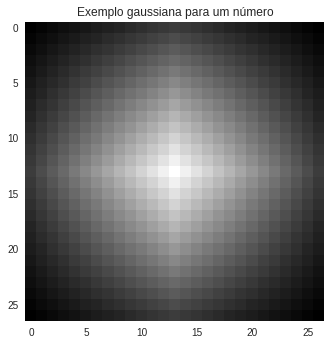

In [7]:
target = np.zeros((27,27))
i,j = np.indices((27,27))
target = ((27 - abs(13-i)*1.42)*(27 - abs(13-j)*1.42)) / (27*27)

plt.imshow(target, cmap='gray')
plt.title('Exemplo gaussiana para um número')
plt.grid(False)
plt.show()

#### Criação do dataset com target personalizado e dataloader

In [0]:
class ChangeTarget(Dataset):
    def __init__(self, dataset,train=True):
      
        self.dataset = dataset
        self.train = train
        
        perc = np.zeros((28,28))
        i,j = np.indices((27,27))
        perc[:27,:27] = ((27 - abs(13-i)*1.42)*(27 - abs(13-j)*1.42)) / (27*27)
        perc[27,:] = 0.1
        perc[:,27] = 0.1
        
        self.num = perc
        self.other = (1-perc)/9
            
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
      
      
        label = self.dataset[index][1].item()
            
        target = np.zeros((10,28,28))
        
        target[:] = self.other
        target[label] = self.num
        
#         for i in range(27): # percorrer pixel a pixel do boundbox
#             for j in range(27): # a formula a seguir considera uma simetria de deslocamento
#                 perc = ((27 - abs(13-i)*1.42)*(27 - abs(13-j)*1.42)) / (27*27)
#                 target[label,i,j]= perc
#                 target[:label,i,j] = (1 - perc)/9 # canais restantes
#                 target[label+1:,i,j] = (1 - perc)/9
#         target[:,27,:] = 0.1
#         target[:,:,27] = 0.1
        
#         if self.train:
#             return self.dataset.train_data[index:index+1].float(), torch.tensor(target).float()
          
        return self.dataset[index][0], torch.tensor(target).float()

In [0]:
train_dataset = ChangeTarget(datasets['train'])
val_dataset = ChangeTarget(datasets['val'], train=False)

train_dataloader = DataLoader(train_dataset, 
                         batch_size=32,
                         shuffle=False)
val_dataloader = DataLoader(val_dataset, 
                         batch_size=32,
                         shuffle=False)

### Visualização de algumas amostras do dataset, via dataloader, usando o grid para visualizar os 10 canais de uma amostra.

In [0]:
im, target = next(iter(train_dataloader))

- ###  Exemplo 1

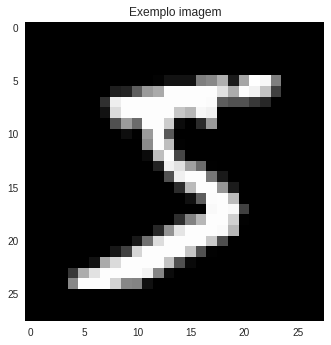

In [11]:
plt.imshow(im[0,0], cmap='gray')
plt.title('Exemplo imagem')
plt.grid(False)
plt.show()

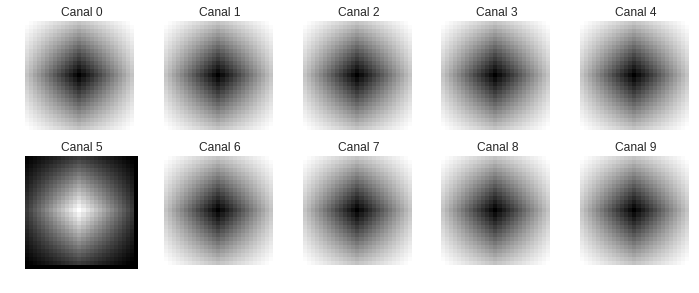

In [12]:
plt.figure(figsize=(12,12))

for i in range(10):
  plt.subplot(5,5,1+i)
  plt.imshow(target[0,i,:,:], cmap='gray')
  plt.axis('off')
  plt.title('Canal '+str(i))
  plt.grid(False)
  
plt.show()

- ### Exemplo 2

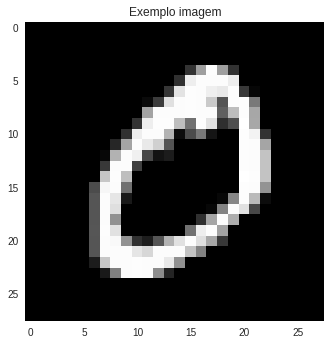

In [13]:
plt.imshow(im[1,0], cmap='gray')
plt.title('Exemplo imagem')
plt.grid(False)
plt.show()

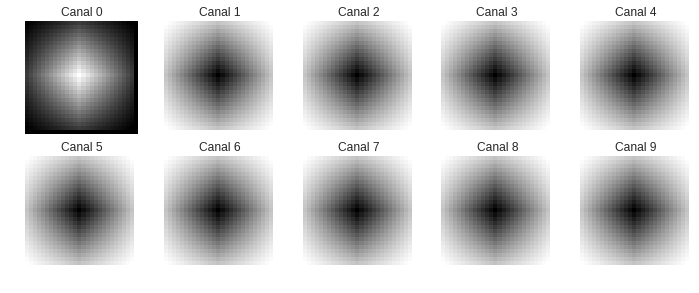

In [14]:
plt.figure(figsize=(12,12))

for i in range(10):
  plt.subplot(5,5,1+i)
  plt.imshow(target[1,i,:,:], cmap='gray')
  plt.axis('off')
  plt.title('Canal '+str(i))
  plt.grid(False)
  
plt.show()

## Criação do modelo totalmente convolucional


In [0]:
class MyModelFullyConv2(nn.Module):
    def __init__(self):
        super(MyModelFullyConv2, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            
            ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)),   
            ('relu1', nn.ReLU()),
            
            ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)),   
            ('relu2', nn.ReLU()),
            
            ('max_pool1', nn.MaxPool2d(2)),
            
            ('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)),
            ('relu3', nn.ReLU()),
            
            ('max_pool2', nn.MaxPool2d(2)),
            
            ('conv4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)),
            ('relu4', nn.ReLU()),
            
            ('conv_t1', nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)),
            ('relu_t1', nn.ReLU()),
            
            ('conv5', nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)),
            ('relu5', nn.ReLU()),
            
            ('conv_t2', nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)),
            ('relu_t2', nn.ReLU()),
            
            ('conv6', nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)),   
            ('relu6', nn.ReLU()),
            
            ('conv7', nn.Conv2d(in_channels=32, out_channels=10, kernel_size=5, padding=2)),   
            
            ('softmax', nn.Softmax2d())
            
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)        
        return x

### Instanciar o modelo e fazer um predict de uma pequena parte do minibatch via dataloader

In [0]:
model = MyModelFullyConv2()

model = model.to(device)

## 3. Preparação para o Treino

In [0]:
# Calcula o erro pelo MSE das probabilidades
criterion = nn.MSELoss()

# Otimizador
optimizer = torch.optim.Adam(model.parameters())

trainer = ptt.DeepNetTrainer(
    model       = model, 
    criterion   = criterion, 
    optimizer   = optimizer,
    # Diminui o valor de lr por um fator de 0.1 a cada 7 epocas
    lr_scheduler= lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
    callbacks   = [
                   ptt.PrintCallback(),
                   ptt.ModelCheckpoint('models/MNIST_multiplo', reset=True, verbose=1)
                  ],
    devname     = device
)

### Treinamento

In [64]:
retrain = True
if retrain:
    trainer.fit_loader(n_epochs=15, train_data=train_dataloader, valid_data=val_dataloader)
else:
    trainer.load_state('models/MNIST_multiplo')

Start training for 15 epochs
  7:  66.4s   T: 0.00001 *   V: 0.00001    
  8:  65.4s   T: 0.00000 *   V: 0.00001 *  
  9:  65.1s   T: 0.00000 *   V: 0.00001 *  
 10:  65.4s   T: 0.00000 *   V: 0.00001 *  
 11:  65.4s   T: 0.00000 *   V: 0.00001 *  
 12:  65.4s   T: 0.00000 *   V: 0.00001 *  
 13:  65.4s   T: 0.00000 *   V: 0.00001 *  
 14:  65.3s   T: 0.00000 *   V: 0.00001 *  
Stop training at epoch: 14/21
Best model was saved at epoch 14 with loss 0.00001: models/MNIST_multiplo


## Predict na imagem com 1 digito

In [0]:
im, target = next(iter(val_dataloader))

In [0]:
pred = trainer.predict(im[1:2])

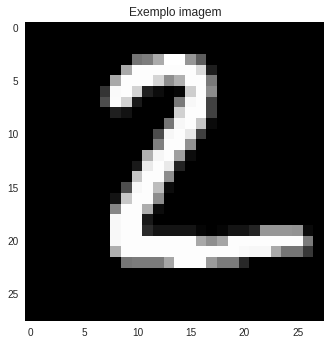

In [67]:
plt.imshow(im[1,0], cmap='gray')
plt.title('Exemplo imagem')
plt.grid(False)
plt.show()

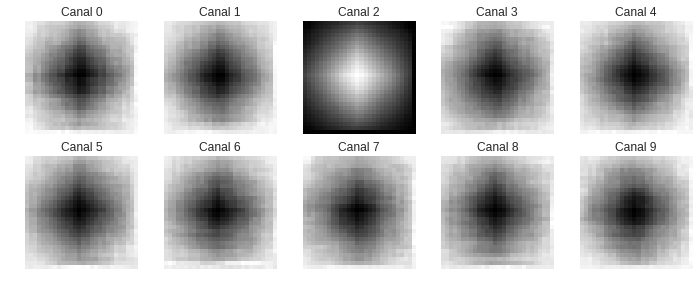

In [68]:
plt.figure(figsize=(12,12))

for i in range(10):
  plt.subplot(5,5,1+i)
  plt.imshow(pred[0,i,:,:], cmap='gray')
  plt.axis('off')
  plt.title('Canal '+str(i))
  plt.grid(False)
  
plt.show()

In [69]:
# maximo de cada canal
for i in range(10):
  print('Máximo canal %d: %.2f' % (i,pred[0][i].max()))

Máximo canal 0: 0.10
Máximo canal 1: 0.11
Máximo canal 2: 0.95
Máximo canal 3: 0.11
Máximo canal 4: 0.10
Máximo canal 5: 0.11
Máximo canal 6: 0.11
Máximo canal 7: 0.11
Máximo canal 8: 0.11
Máximo canal 9: 0.10


## Predict na imagem ampliada, com vários dígitos

### Exemplo de programa para gerar a imagem de teste

In [0]:
class MultiMNIST():
    '''
    Gera imagens de qualquer tamanho com n 28x28 numeros mnist aleatoriamente colocados sem overlap 
    ''' 
    def __init__(self, root='.', mode="train", donwload=True, transform=None, image_size=(200, 200), number_size=(28, 28), mnist_batch=10):
        '''
        Nomes dos argumentos self explanatory
        '''
        self.image_size = image_size  # tamanho da imagem de saida
        self.number_size = number_size  # tamanho do mnist
        self.anchor_space = np.array(image_size) - np.array(number_size)  # espaço onde podem existir ancoras (top-left)
        self.mnist_batch = mnist_batch  # quantidade de numeros por sample
        
        # Inicializar MNIST para pegar imagens
        mnist_transforms = {'train': transforms.ToTensor(), 'validation': transforms.ToTensor()}
        mnist = MNIST(root=root, train=mode=='train', transform=mnist_transforms[mode], download=True)
        self.mnist_loader = DataLoader(mnist, batch_size=mnist_batch, shuffle=True, num_workers=0)
        self.mnist_size = len(mnist)
        self.iter = iter(self.mnist_loader)
        
    def non_overlaping_anchor_points(self):
        '''
        Gera pontos de ancora que não se cruzam para colocar numeros 
        '''
        npoints = self.mnist_batch
        
        anchor_points = (np.random.rand(npoints, 2)*self.anchor_space).astype(np.int)  # pontos de ancora (top-left) aleatorios dentro do anchor_space
        minimum_distance = int(sqrt(pow(self.number_size[0], 2) + pow(self.number_size[1], 2)))  # distancia minima entre ancoras é diagonal do retângulo
        
        # Enquanto o numero de retangulos com overlap for maior que npoints continue tentando
        i = 1
        while True:
            noverlap = -npoints
            for p1 in anchor_points:
                for p2 in anchor_points:
                    dist = np.linalg.norm(p1-p2)
                    if dist < minimum_distance:  # hypotenuse of number rectangle is minimum distance
                        noverlap += 1
            if noverlap < 1:
                return anchor_points
            else:
                anchor_points = (np.random.rand(npoints, 2)*self.anchor_space).astype(np.int)
            if i % 10000 == 0:
                print("WARNING: {} iterations trying to find random number placement.".format(i))
            i += 1
    
    def make_sample(self):
        '''
        Faz uma sample com varios numeros do mnist separados
        '''
        imgs, _ = next(self.iter)
        anchor_points = self.non_overlaping_anchor_points()
                    
        sample = np.zeros(self.image_size)
        
        for point, img in zip(anchor_points, imgs):
            sample[point[0]:point[0]+28, point[1]:point[1]+28] = img.squeeze().numpy()
            
        return sample
    

In [0]:
m_mnist = MultiMNIST(image_size=(200,200), mnist_batch=10)

In [0]:
im = torch.tensor(m_mnist.make_sample()).float()

In [0]:
im = im.reshape(1,1,im.shape[0],im.shape[1])

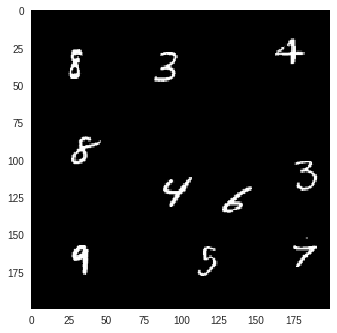

In [92]:
plt.imshow(im[0,0], cmap="gray")
plt.grid('off')
plt.show()

In [0]:
pred = trainer.predict(im)

## Mapas de calor (máximo probabilidades) e de classes

In [0]:
heatmap, _ = pred[0].max(dim=0)

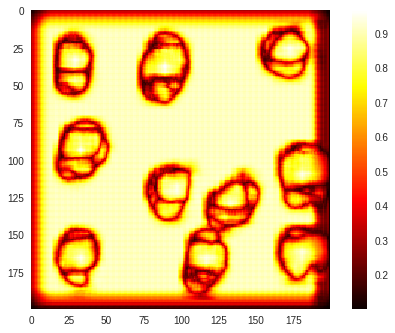

In [95]:
plt.imshow(heatmap,plt.cm.hot)
plt.grid('off')
plt.colorbar()
plt.show()

### Non Maxima Supression aplicado no mapa de calor

- pode-se usar a solução aproximada por morfologia
- usar os algoritmos genéricos para qq tamanho de bounding box:

  - https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
  - solução no github:
    -  Original author: Francisco Massa:
    - https://github.com/fmassa/object-detection.torch
    - Ported to PyTorch by Max deGroot (02/01/2017)

In [0]:
def get_boxes(pred,size=(27,27),threshold=0.5):
    bbox = []
    prob = []
    num = []
    x = int(size[1]/2)
    y = int(size[0]/2)
    
    for i in range(pred.shape[1]):
        for j in range(pred.shape[2]):
            arg = np.argmax(pred[:,i,j])
            if((pred[arg,i,j]>threshold) and (i>=y) and (j>=x)):
              prob.append(pred[arg,i,j])
              num.append(arg)
              bbox.append([j-x,i-y,j+x,i+y])
    bbox = np.array(bbox)
    return bbox, num, prob

In [0]:
def non_max_suppression(bbox, num, prob, threshold=0):
    pick_bbox = []
    pick_num = []
    while len(bbox)>0:

        x1 = bbox[:,0]
        y1 = bbox[:,1]
        x2 = bbox[:,2]
        y2 = bbox[:,3]


        idx = np.argmax(prob)
        pick_bbox.append(bbox[idx])
        pick_num.append(num[idx])

        xx1 = np.maximum(x1[idx], x1)
        yy1 = np.maximum(y1[idx], y1)
        xx2 = np.minimum(x2[idx], x2)
        yy2 = np.minimum(y2[idx], y2)

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        area = w*h
        overlap = area/area[idx]
        bbox = np.delete(bbox,np.where(overlap > threshold)[0],axis=0)
        num = np.delete(num, np.where(overlap > threshold)[0])
        prob = np.delete(prob, np.where(overlap > threshold)[0])
    
    return pick_bbox, pick_num
    
  

In [0]:
bbox, num, prob = get_boxes(pred[0],threshold=0.94) # threshold de 0.8 para garantir os boundboxes corretos
bbox, num = non_max_suppression(bbox,num,prob)

In [99]:
len(bbox)

10

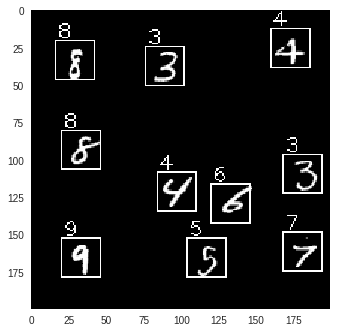

In [100]:
sample = im[0,0].numpy()*255
for i in range(len(bbox)):
    cv.rectangle(sample, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 255)
    cv.putText(sample, str(num[i].item()), (bbox[i][0]+1, bbox[i][1]-1), cv.FONT_HERSHEY_PLAIN, 1, 255)

plt.grid(False)
plt.imshow(sample, cmap='gray')    

1.0